#RL Project 2
In this project we try to implement the deep Q network based algorithms to solve reinforcemnt learning problems. In part 1 of the project we implement Deepmind's paper on 'Learning Atari with Deep Reinforcement Learning', and then apply it on two OpenAI gym environments.
In part 2 of the project we improve upon the DQN algorithm by implementing the Double-DQN algorithm and we apply that algorithm on one of the environments from part 1.

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from IPython import display as ipythondisplay
from collections import deque

Using TensorFlow backend.


##Part 1.1 - Implementing DQN
Here we implement the DQN algorithm from DeepMind's paper on 'Learning Atari with Deep Reinforcement Learning' from scratch. The DeepMind paper made 3 improvements over normal DQN, which are as follows - 
*   Experience Replay
*   Use Target Q Network 
*   Reward Clipping

We explain each of these in detail and also our implementation of each of these below-


1.   Experience Replay - The basic problem with training Neural Network to learn the Q-values given the state transition data is that the state transition date is sequential in nature and a neural network which is primary used in machine learning works on the assumption that the input data is independent of each other. So break this correlation between the input data samples, we use experience replay, wherein we create a mini database of transition data and then randomly sample a mini-batch from this transition database. This way we ensure that our training data isn't sequential. In our implementation we use a python queue to implement the database, the size of our queue is 512 and after it fills up we remove the oldest entry to make space for the new one.
2.   Target Q Network - Another problem with using a neural network to train on transition data is that unlike conventional machine learning where our target is a fixed a training sample here our target is actually a function of the ouput of the neural network, i.e.

  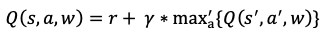

  Here as we can see in the above equation our target value is dependent on the prediction of Q value of the next state, so as our network learns to achieve the target, the target itself keeps moving. So to resolve this we use two neural networks one is called the target neural network and the other is the prediction network. The idea behind this is that the target network is kept fixed while the prediction network tries to achieve the target network. And after a certain number of training steps the target network is updated with the weights of prediction network. This helps to keep the training stable.
  In our implementation we use two identical neural networks for target and prediction. The details of our network are - 
  *   One hidden layer (densely connected) of size 128 and activation function relu
  *   Output layer of size of the numebr of actions, activation linear
  *   We use SGD as the optimiser and mean squared error as our loss function
3.   Reward Clipping - We clip the rewars to -1,0,1 for the our agent as lower rewards help in faster calculations and also the value of cummulative return stays low.











In [0]:
#dqn agent class
class DQNAgent:
  def __init__(self, myEnv):
    self.state_size= myEnv.observation_space.shape[0]
    self.action_size=myEnv.action_space.n
    self.memory=deque(maxlen=3000)
    self.gamma=0.9
    self.epsilon=1.0
    self.epsilon_decay=0.999
    self.epsilon_min=0.001
    self.learning_rate=0.001
    self.predictionModel=self._build_model()
    self.targetModel=self._build_target_model()
  
  #func to build prediction model
  def _build_model(self):
    model = Sequential()
    model.add(Dense(128,input_dim=self.state_size,activation='relu'))
    model.add(Dense(self.action_size,activation='linear'))
    model.compile(loss='mse',optimizer=SGD(lr=self.learning_rate))
    return model

#func to build the target network
  def _build_target_model(self):
    model = Sequential()
    model.add(Dense(128,input_dim=self.state_size,activation='relu'))
    model.add(Dense(self.action_size,activation='linear'))
    model.compile(loss='mse',optimizer=SGD(lr=self.learning_rate))
    return model
  
  #fucn to store transition in memory
  def storeTransition(self, transition):
    self.memory.append(transition)
  
  #func to choose an action using epsilon greedy policy
  def chooseAct(self,state):
    prob=random.random()
    if(prob<=self.epsilon):
      return random.randrange(self.action_size)
    qVals=self.predictionModel.predict(state)
    return np.argmax(qVals)
  
  #func to train the network
  def train(self,inputSize,t_step):
    inputLayer = random.sample(self.memory,inputSize)
    qVals=[]
    for k,transit in enumerate(inputLayer):
      if(transit[4]!=True):
        target= transit[2]+ self.gamma * np.amax(self.targetModel.predict(transit[3])[0]) #get the true Q-value for the performed action
      else:
        target=transit[2]
      
      qTar=self.targetModel.predict(transit[0])
      qTar[0][transit[1]]=target
      qTar=np.reshape(qTar,[self.action_size,])
      qVals.append(qTar)
    trainX=[]
    for i in inputLayer:
      st=i[0]
      st=np.reshape(i[0],[self.state_size,])
      trainX.append(st)
    trainX=np.asarray(trainX)
    qVals=np.asarray(qVals)
    self.predictionModel.fit(trainX,qVals,epochs=1,verbose=0) #perform gradient descent on the prediction network
    
 #func to update the weights of target network 
  def updateTarget(self):
    self.targetModel.set_weights(self.predictionModel.get_weights())

##1.2 Using DQN on OpenAI Gym environments

Here we apply the DQN we implemented above on two OpenAI gym environments. We choose Cartpole and MountainCar environments for this part. We explain our trining parameters briefly for both environemnts below -


*   CartPole 
  
  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright and everytime it fails we give it a reward of -1. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center or after a maximum timestep of 200.
  The state of tbe agent is represented by 4 features - cart position, cart velocity, pole angle, pole velocity at tip.
  
  The action state is discrete with two possible actions - push cart left or right.

  We train our network for 2000 episodes and in every episode we go for a maximum of 200 timesteps. We store our transitions in a queue of size 512 and dont perform any training till the queue is full. To keep track and observe the training we store the total reward for every episode and plot it side by side. As an episode terminates automatically after a maximum of 200 timesteps the maximum reward possible for every episode is 200.

  We observe that after close to 750 episodes the reward per episode starts to increase and it increases steadily thereafter and by the time it reaches 2000 episodes we can see that the reward per episode is in the range of 100-175. Training the network for 2000 episodes took a lot of time and we believe that if we continue to train for more episodes it will easily reach 200 reward per episode, however due to compute resource restriction we stopped at 2000 episodes.
*   Mountain Car

  "A car is on a one-dimensional track, positioned between two "mountains". The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum."

  In this environment we have to drive a car uphill to reach the goal given by the position 0.5 on x-axis, the starting postion of the car is at -0.4.
  State is represented by two features- the position and velocity of the car.
  
  Action space has three actions - push left, push right, no push
  
  Rewards - We have defined a custom reward for this environment which is :
    
    r = 100 ; if you reach your goal
    
    r = (1 + postion of car)^2 ; if you are ahead of your starting postion

    r = 0 ; if you are behind your starting position

    The motivation behind this was that as the car climbs higher up the hill infront of it, it should get a higher reward and the highest reward should be at goal.

As we train we keep track of the total reward for every episode and plot it for every 20th episode. 

We train this for only 100 episodes as training mountain cart is slower than Cartpole.

As the training progresses we can see that the reward increases steadily but the surprising thing was that it doesn't touch hundred. We tried different hyperparameters but it didn't touch 100.

In [0]:
#method to train CartPole environemnt on DQN and DDQN
def train_model(env,agentName):
  if(agentName=="DQN"):
    agent = DQNAgent(env)
  else:
    agent = DDQNAgent(env)
  rewardz=[] #lsit to store reward
  t_step=0
  for episode in range(2000): #run for 2k episodes
    state=env.reset()
    state=np.reshape(state,[1,env.observation_space.shape[0]])
    for transition in range(200):
      action=agent.chooseAct(state) #perform action based epsilon greedy policy
      next_state,reward,done, _ = env.step(action) #perform the action
      next_state=np.reshape(next_state,[1,env.observation_space.shape[0]])
      if(done):
        reward=-1 #the pole falls reward is -1
      transit_tuple=(state,action,reward,next_state,done)
      agent.storeTransition(transit_tuple) #store the transition in memory
      if(len(agent.memory)>=512):
        agent.train(32,t_step) #train the network on minibatch of size 32
      state=next_state
      t_step+=1
      if(done==True):
        rewardz.append(transition) #store the length of episode
        break
    
    #perform epsilon decay
    if(len(agent.memory)>=512 and agent.epsilon > agent.epsilon_min):
      agent.epsilon*=agent.epsilon_decay
    #if DQN update the target network
    if(agentName=="DQN" and episode%20==0 and len(agent.memory)>=512):
      #print("Updating")
      agent.updateTarget()
    #plot the reward
    if(episode%200==0):
      plt.plot(rewardz)
      plt.show()
      print(agent.epsilon)
  return agent

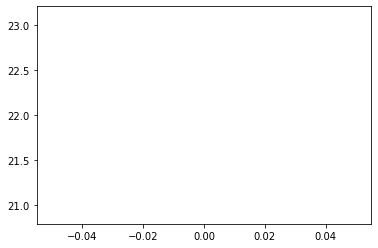

1.0


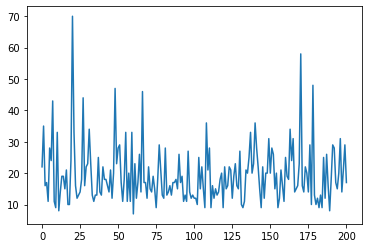

0.8351949903256736


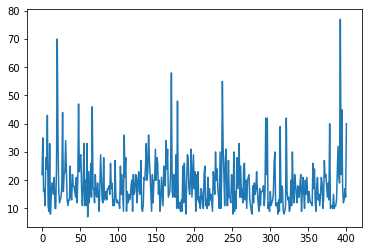

0.6837314012165328


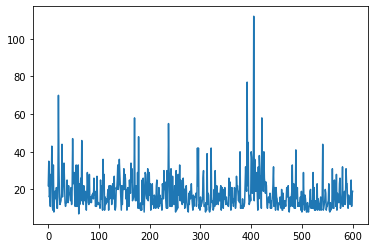

0.5597359112837013


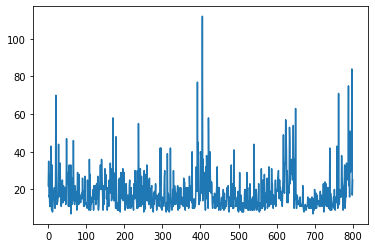

0.45822714858955943


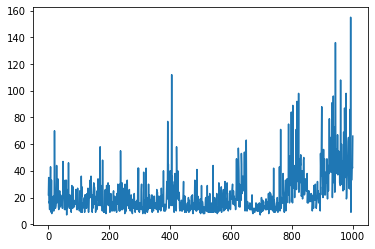

0.3751271188281757


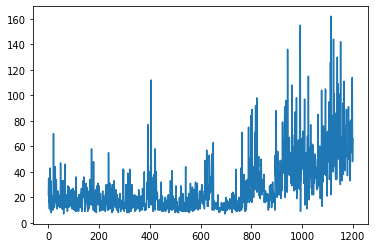

0.30709737673437937


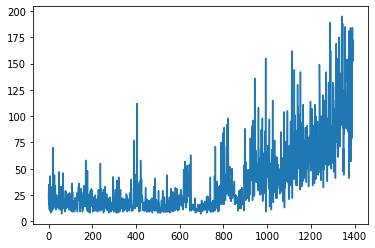

0.25140490799955945


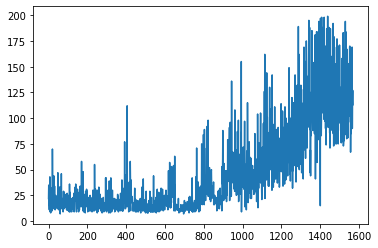

0.20581233365902327


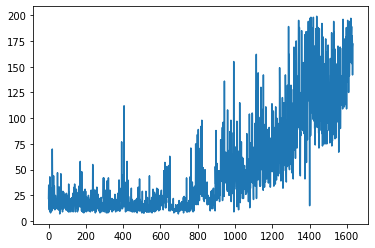

0.1684880260422258


In [34]:
#train the Cartpole environment on DQN
env = gym.make('CartPole-v1')
dqnAgent=train_model(env,"DQN")

In [0]:
def train_model1(env,agentName):
  if(agentName=="DQN"):
    agent = DQNAgent(env)
  else:
    agent = DDQNAgent(env)
  tot_rewardz=[]
  t_step=0
  for episode in range(100):
    state=env.reset()
    state=np.reshape(state,[1,env.observation_space.shape[0]])
    rewardz=[]
    for transition in range(500):
      action=agent.chooseAct(state)
      next_state,reward,done, _ = env.step(action)
      
      if (next_state[0] >= 0.5):
        print("Target Reached")
        reward= 100
      elif (next_state[0] > -0.4):
        reward= (1+next_state[0])**2
        #reward= (next_state[0]+0.4)
      else:
        reward= 0
      
      next_state=np.reshape(next_state,[1,env.observation_space.shape[0]])
      transit_tuple=(state,action,reward,next_state,done)
      agent.storeTransition(transit_tuple)
      if(len(agent.memory)>=512):
        agent.train(8,t_step)
      state=next_state
      t_step+=1
      rewardz.append(reward)
      if(len(agent.memory)>=512 and agent.epsilon > agent.epsilon_min and transition%5==0):
        agent.epsilon*=agent.epsilon_decay
      if(done==True):
        break 
      
    avg_rew=np.sum(rewardz)
    tot_rewardz.append(avg_rew)
    
    if(agentName=="DQN" and episode%20==0):
      agent.updateTarget()
    if(episode%20==0):
      plt.plot(tot_rewardz)
      plt.show()
      print(agent.epsilon)
  return agent

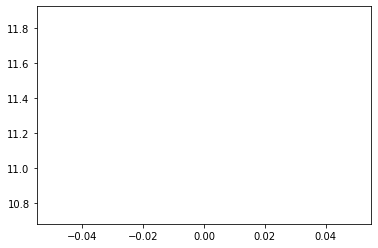

1.0


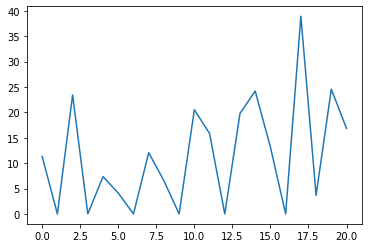

0.47837097658906735


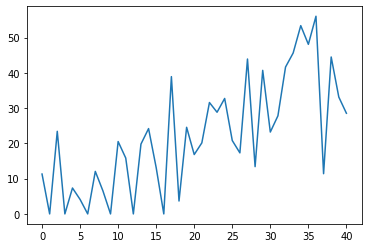

0.21485991685474995


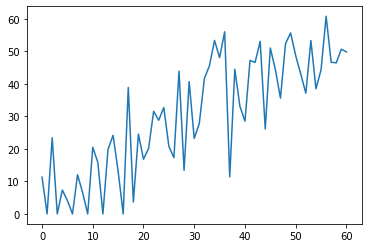

0.09650414872574241


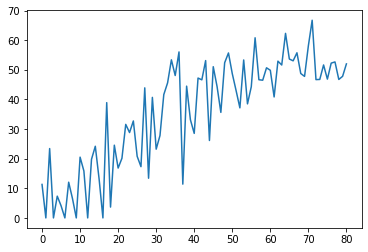

0.043344756237507366


In [90]:
#train the mountain car on DQN
env2=gym.make('MountainCar-v0')
dqnPend=train_model1(env2,"DQN")

##Part 2-  DDQN
In part 2 of the project we implement an improved upon version of the DQN algorithm - the Double DQN. One of the problems with DQN is that it overestimates the Q value for the action which has the maximum Q value. To overcome this Double DQN uses two networks - primary network and the target network. The target network is used to get the action with the maximum value however the corresponding Q value for that state, action pair is calculated using the primary network, whereas both the above tasks were done by the same network.

In [0]:
#class for DDQN agent
class DDQNAgent:
  #func to initialise the hyperparameters of ddqn agent
  def __init__(self, myEnv):
    self.state_size= myEnv.observation_space.shape[0]
    self.action_size=myEnv.action_space.n
    self.memory=deque(maxlen=3000)
    self.tau=0.0015
    self.gamma=0.9
    self.epsilon=1.0
    self.epsilon_decay=0.999
    self.epsilon_min=0.001
    self.learning_rate=0.005
    self.primaryModel=self._build_model()
    self.targetModel=self._build_target_model()
  
  #func to build the primary model
  def _build_model(self):
    model = Sequential()
    model.add(Dense(128,input_dim=self.state_size,activation='relu'))
    model.add(Dense(self.action_size,activation='linear'))
    model.compile(loss='mse',optimizer=SGD(lr=self.learning_rate))
    return model

#func to build the target model
  def _build_target_model(self):
    model = Sequential()
    model.add(Dense(128,input_dim=self.state_size,activation='relu'))
    model.add(Dense(self.action_size,activation='linear'))
    model.compile(loss='mse',optimizer=SGD(lr=self.learning_rate))
    return model
  
  #func to store the transition in memmory
  def storeTransition(self, transition):
    self.memory.append(transition)
  
  #func to choose an action to perform
  def chooseAct(self,state):
    prob=random.random()
    if(prob<=self.epsilon):
      return random.randrange(self.action_size)
    qVals=self.primaryModel.predict(state)
    return np.argmax(qVals)
  
  #func to train the network
  def train(self,inputSize,t_step):
    inputLayer = random.sample(self.memory,inputSize)
    qVals=[]
    for k,transit in enumerate(inputLayer):
      if(transit[4]!=True):
        act=np.argmax(self.targetModel.predict(transit[3])[0])
        target= transit[2]+ self.gamma * self.primaryModel.predict(transit[3])[0][act] #get the true Q-value for the given state and action
      else:
        target=transit[2]
      qTar=self.targetModel.predict(transit[0])
      qTar[0][transit[1]]=target
      qTar=np.reshape(qTar,[self.action_size,])
      qVals.append(qTar)
    trainX=[]
    for i in inputLayer:
      st=i[0]
      st=np.reshape(i[0],[4,])
      trainX.append(st)
    trainX=np.asarray(trainX)
    qVals=np.asarray(qVals)
    self.primaryModel.fit(trainX,qVals,epochs=1,verbose=0) #perform gradient descent
    primary_wt=self.primaryModel.get_weights()
    primary_wt = [self.tau * i for i in primary_wt]
    sec_wt= self.targetModel.get_weights()
    sec_wt = [(1-self.tau) * i for i in sec_wt]
    new_target_wt = primary_wt + sec_wt
    self.targetModel.set_weights(new_target_wt) #update weights for the target network

We train our DDQN on CartPole environment we keep the neural networks from the DQN implementation but change the training part for DDQN algorithm instead. We train it on 2000 episodes like with DQN and 200 transitions per episode. While training we plot the total amount of timesteps the game was played for every episode and print the epsilon value for that episode alongside.

As we can see the number of timesteps/episode starts to increase form around episode 700 but staturates around 1200th episode, we tried to change the learning rate hoping that a larger learning rate would avoid the network being stuck at a local minima but it had little effect on the learning as it only increased slightly.

So basically the DDQN algorithm learns the Cartpole environment but not as good as the DQN algorithm.

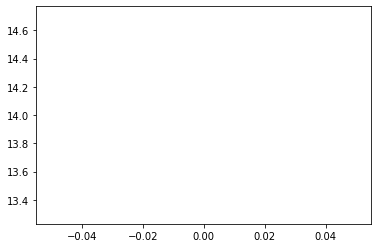

1.0


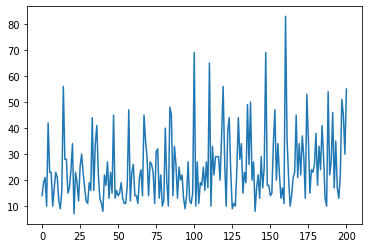

0.8360310213470206


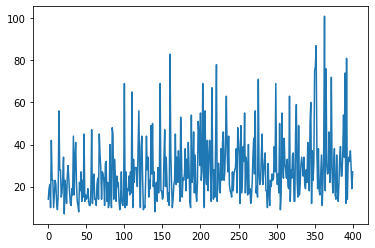

0.6844158170335664


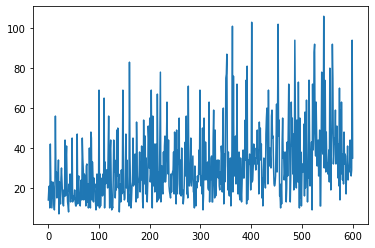

0.5602962074911925


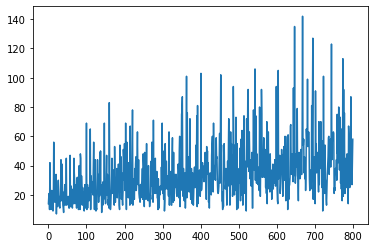

0.4586858344239834


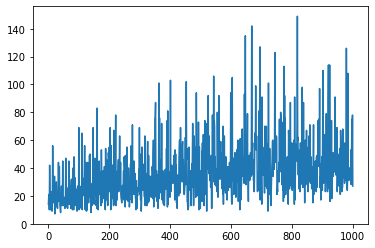

0.3755026214496253


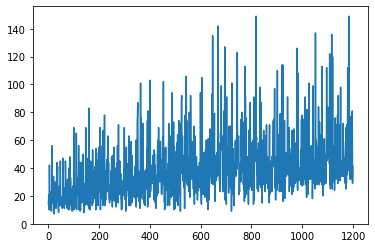

0.3074047815158953


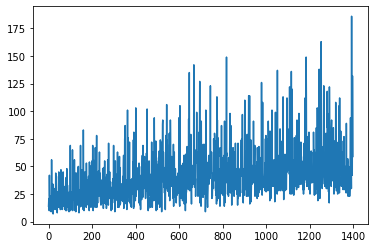

0.25165656456412355


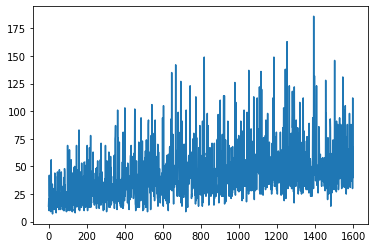

0.2060183520110343


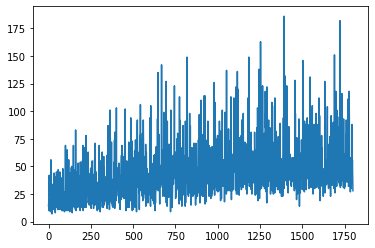

0.16865668272495074


In [0]:
#apply ddqn on CartPole
env = gym.make('CartPole-v1')
ddqnAgent=train_model(env,"DDQN")

###References
1. Course Slides
2. https://towardsdatascience.com/solving-reinforcement-learning-classic-control-problems-openaigym-1b50413265dd